# Exercise 1.5.2 - Mean Average Precision (mAP)
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Implement the Mean Average Precision (mAP) metric;
* To do so, create a function to calculate the [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) scores;
* Visualise the Precision-Recall (PR) curve and smoothed PR curve.
* Compute the mAP over the provided test data (a frame from the [Waymo Open Dataset](https://waymo.com/open)).

## 1. Introduction

In [1]:
### Importing the required modules

In [2]:
from collections import Counter
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from typing import List, Union

In [3]:
#tf.__version__

In [4]:
#tf.test.gpu_device_name()

In [5]:
### Setting the environment variables

In [6]:
ENV_COLAB = False                # True if running in Google Colab instance

In [7]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [8]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')
# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

In [9]:
### Creating subdirectories (if not exists)
os.makedirs(DIR_OUT, exist_ok=True)

### 1.1. Mean Average Precision (mAP)

#### Background

[Mean Average Precision](https://en.wikipedia.org/wiki/Evaluation_measures_\(information_retrieval\)#Mean_average_precision) (mAP) is a widely-used accuracy metric for object detection models. As the name entails, mAP is simply the average of the [Average Precision](https://en.wikipedia.org/wiki/Evaluation_measures_\(information_retrieval\)#Average_precision) (AP) computed with respect to all classes.

#### Precision and Recall

[Precision](https://en.wikipedia.org/wiki/Precision_and_recall#Precision) and [recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall) (sometimes called [sensitivity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)) are two single-valued metrics often computed over the entire document set (in our case, the set of all predictions made). We can, however, also compute precision and recall at every step along that interval. 

In other words, we can compute these two metrics cumulatively, prediction-by-prediction.

##### Precision-Recall (PR) curve

We can use the cumulative precision and recall calculations to plot a Precision-Recall curve. In order to generate the points along this curve, we have to calculate the _true positive_, _false positive_, _true negative_ and _false negative_ rate over a set of of predictions and their ground truth labels:

$$
\begin{align*}
    \mathrm{Precision} &= \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}} = \frac{\mathrm{TP}}{\mathrm{all \ detections}}, &
    \mathrm{Recall} &= \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}} = \frac{\mathrm{TP}}{\mathrm{all \ ground \ truths}}.
\end{align*}
$$

Often times the resulting PR curve will have extremes (jagged peaks) and result in a less-accurate area under the curve (AUC) calculation. To fix this, two common [interpolation](https://en.wikipedia.org/wiki/Interpolation) techniques are used to smooth out the PR curve.

###### Interpolation

The [11-Point Interpolation](https://github.com/rafaelpadilla/Object-Detection-Metrics#11-point-interpolation) technique pioneered by Everingham et al., 2010 [1] attempts to summarise the shape of the Precision $x$ Recall curve by averaging the precision values at a set of eleven equally-spaced recall levels in the range $[0, 1]$,

$$
\begin{align*}
\mathrm{AP} &= \frac{1}{11} \sum_{r \ \in \ \{0, 0.1, .., 1\}} \rho_{\mathrm{interp}}(r), \quad
& \rho_{\mathrm{interp}}(r) &= \max_{\bar{r}:\bar{r} \geq r}(\tilde{r}).
\end{align*}
$$

where $\rho(\tilde{r})$ is the measured precision at recall $\tilde{r}$. The precision value at each observed point is not used to compute the PR curve, instead the $AP$ value is obtained by interpolation the precision only at these $r=11$ levels. The precision is determined to be the maximum precision value whose recall is greater than $r$.

The [All-Points Interpolation](https://github.com/rafaelpadilla/Object-Detection-Metrics#interpolating-all-points) [2] method extends the 11-Points method to a set of recall levels $n$ equal to the number of observations along the Precision $x$ Recall curve, such that

$$
\begin{align*}
\mathrm{AP} &= \frac{1}{n} \sum_{n=0} \left(r_{n+1} - r_{n}\right) \rho_{\mathrm{interp}}(r_{n+1}), \quad
& \rho_{\mathrm{interp}}(r_{n+1}) &= \max_{\bar{r}:\bar{r} \geq r_{n+1}}(\tilde{r}).
\end{align*}
$$

where $p(\tilde{r})$ is the measured precision at recall $\tilde{r}$. Instead of using precision observed at only $r = 11$ points, we can now obtain the average precision (AP) by interpolating at each level $r$ and taking the maximum precision value whose recall is greater than $r + 1$. 

## 2. Programming Task

### 2.1. Precision-Recall

#### IoU algorithm in Python

In [10]:
### From J. Moran's `2022-07-25-Choosing-Metrics-IoU.ipynb`

In [11]:
class IoU:

    def __init__(self):
        return

    @staticmethod
    def _overlapping_rectangles(bbox1: List[int], bbox2: List[int]) -> bool:
        """Returns True if the bounding boxes overlap.
        
        Two bounding boxes overlap if their area is positive and non-zero.
        
        :param bbox1: 1x4 list of x-y coordinates forming a rectangle.
        :param bbox2: 1x4 list of x-y coordinates forming a rectangle.
        :returns: bool, whether or not the two rectangles overlap.
        """
        
        # 1. Check if bounding boxes do not overlap
        if (
            # (a) First bbox lower edge is GEQ second bbox upper edge
            (min(bbox1[1], bbox2[1]) >= max(bbox1[3], bbox2[3])) or
            # (b) First bbox right edge is LEQ second bbox left edge
            (min(bbox1[2], bbox2[2]) <= max(bbox1[0], bbox2[0])) or
            # (c) First bbox left edge is GEQ second bbox right edge
            (min(bbox1[0], bbox2[0]) >= max(bbox1[2], bbox2[2])) or
            # (d) First bbox upper edge is LEQ second bbox lower edge
            (min(bbox1[3], bbox2[3]) <= max(bbox1[1], bbox2[1]))
        ):
            return False
        # 2. Check if intersection area is larger than 0
        else:
            x_inter1 = max(bbox1[0], bbox2[0])
            y_inter1 = max(bbox1[1], bbox2[1])
            x_inter2 = min(bbox1[2], bbox2[2])
            y_inter2 = min(bbox1[3], bbox2[3])
            # Overlapping region must have positive area
            w_inter = max(0, (x_inter2 - x_inter1))
            h_inter = max(0, (y_inter2 - y_inter1))
            if (w_inter * h_inter) > 0:
                return True
        return False

    def _calculate_iou(self, gt_bbox: List[int], pred_bbox: List[int]) -> float:
        """Calculates the IoU score for a single pair of bounding boxes.

        :param gt_bbox: 1x4 list of ground-truth coordinates.
        :param pred_bbox: 1x4 list of predicted coordinates.
        returns: iou, the pairwise IoU score between the two bounding boxes.
        """

        # 1. Check if bounding boxes overlap
        if not self._overlapping_rectangles(gt_bbox, pred_bbox):
            return 0.0
        else:
            # 2. Find the coordinates of the area of intersection
            #    2a. The upper-left coordinate
            x_inter1 = max(gt_bbox[0], pred_bbox[0])
            y_inter1 = max(gt_bbox[1], pred_bbox[1])
            #    2b. The lower-right coordinate
            x_inter2 = min(gt_bbox[2], pred_bbox[2])
            y_inter2 = min(gt_bbox[3], pred_bbox[3])
            # 3. Calculate the area of intersection
            w_inter = abs(x_inter2 - x_inter1)
            h_inter = abs(y_inter2 - y_inter1)
            area_inter = w_inter * h_inter
            # 4. Find the coordinates of the area of union
            #    4a. The height and width of the first box 
            w_union1 = abs(gt_bbox[2] - gt_bbox[0])
            h_union1 = abs(gt_bbox[3] - gt_bbox[1])
            #    4b. The height and width of the second box
            w_union2 = abs(pred_bbox[2] - pred_bbox[0])
            h_union2 = abs(pred_bbox[3] - pred_bbox[1])
            # 5. Calculate the area of union
            area_union = (w_union1 * h_union1) + (w_union2 * h_union2)
            area_union -= area_inter
            # 6. Calculate the resulting IoU score
            iou = float(area_inter) / float(area_union)
        return iou

    def calculate_ious(self, gt_bboxes: List[List[int]], 
                       pred_bboxes: List[List[int]]) -> List[float]:
        """Calculates the IoU scores for all bounding box pairs.

        :param gt_bboxes: Nx4 list of ground-truth coordinates,
        :param pred_bboxes: Mx4 list of predicted coordinates,
        returns: iou, NxM list of pairwise IoU scores.
        """

        # Allocate a NumPy array of zeros to store the IoU scores
        ious = np.zeros((gt_bboxes.shape[0], pred_bboxes.shape[0]))
        # For each ground-truth bounding box
        for i, gt_bbox in enumerate(gt_bboxes):
            # Calculate the IoU score w.r.t the entire inference set
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i,j] = self._calculate_iou(gt_bbox, pred_bbox)
        return ious

To do so, you will first have to create the Precision-Recall (PR) curve. Once this curve is created, you need to create the smoothed version as discussed in the lesson. Finally you can use this smoothed version to calculate the mAP.

#### Precision and Recall algorithm in Python

In [12]:
### From J. Moran's `2022-07-25-Choosing-Metrics-IoU.ipynb`

In [13]:
class PrecisionRecall:

    def __init__(self):
        return

    def _compute_class_metrics(
            self, ious: np.ndarray, gt_classes: List[int], pred_classes: List[int], 
            iou_threshold: float
    ) -> List[dict]:
        """Computes the classification metrics for a multi-class dataset.
        
        Dataset contains pairwse IoU scores for the bounding box prediction problem.
        
        :param ious: NxM list of pairwise IoU scores.
        :param gt_classes: 1xN list of ground truth class labels.
        :param pred_classes: 1xM list of predicted class labels.
        :param iou_threshold: float threshold, predictions 'valid' above this value.
        :returns: list of dict objects containing the per-class metrics.
        """
        
        # Store per-class metrics
        cls_metrics = []
        # Convert matrix into pandas DataFrame for easier slicing/indexing
        df = pd.DataFrame(data=ious, index=gt_classes, columns=pred_classes)
        # Compute per-class metrics
        for cls in np.unique(gt_classes):
            # Get all preds for gt cls label
            cls_df = df.loc[[cls],:]    # Preserves DataFrame structure
            try:
                # Get all gt-pred pairs with matching class labels
                cls_data = cls_df[cls]
                # Count number of TP (correct class, IoU > 0.5) predictions
                true_positives = np.count_nonzero(cls_data.where(cls_data > 0.5).fillna(0))
            except KeyError as k:
                print(f"No predicted bounding boxes for class label '{k}'")
            # Count number of TN (i.e., no bounding box to predict, N/A for our data)
            true_negatives = 0
            # Count number of FN (incorrect class, IoU < 0.5) predictions
            false_negatives = np.count_nonzero(cls_df.where(
                                cls_df < 0.5).drop(columns=cls, errors='ignore').fillna(0))
            # Count number of FP (incorrect class, IoU > 0.5) predictions
            false_positives = np.count_nonzero(cls_df.where(
                                cls_df > 0.5).drop(columns=cls, errors='ignore').fillna(0))
            # Calculate precsion/recall for each class and store in dict
            cls_dict = {'TN': true_negatives,
                        'TP': true_positives,
                        'FN': false_negatives,
                        'FP': false_positives
                        }
            cls_metrics.append(cls_dict)
        return cls_metrics

    def precision_recall_rate(
            self, ious: np.ndarray, gt_classes: List[int], pred_classes: List[int], 
            iou_threshold:float=0.5, print_scores: bool=True
    ) -> (float, float):
        """Calculates the precision and recall metrics.
        
        Dataset contains pairwse IoU scores for the bounding box prediction problem.
        Columns are the predicted class labels, rows are the ground truth class labels.
        
        :param ious: NxM list of pairwise IoU scores.
        :param gt_classes: 1xN list of ground truth class labels.
        :param pred_classes: 1xM list of predicted class labels.
        :param iou_threshold: float (optional), thresholds predictions using IoU score,
            predictions with IoU above this threshold are considered 'valid'.
        :param print_scores: boolean (optional), indicate whether or not to print scores
            calculated at each timestep to the console.
        :returns: (precision, recall), the two classification metric values.
        """

        # Compute per-class metrics
        cls_metrics = self._compute_class_metrics(ious, gt_classes, pred_classes, iou_threshold)
        # Store total metrics
        TN_total, TP_total = 0, 0
        FN_total, FP_total = 0, 0
        for c in cls_metrics:
            TN_total += c['TN']
            TP_total += c['TP']
            FN_total += c['FN']
            FP_total += c['FP']
        # Print total metrics
        if print_scores:
            print("TP:", TP_total, "TN:", TN_total, "\nFP:", FP_total, "FN:", FN_total)
        # Compute combined metrics
        precision_rate = TP_total / float(TP_total + FP_total)
        return precision_rate, TP_total
    
    def precision_recall_curve(
        self, ious: np.ndarray, gt_classes: List[int], pred_classes: List[int], 
        iou_threshold: float=0.5, interpolation: str=None, print_scores: bool=False
    ) -> List[Union[float, float]]:
        """Returns the points along the Precision-Recall curve.
        
        Computes the moving precision and recall scores, i.e., up to a cut-off k.
        
        :param ious: NxM list of pairwise IoU scores.
        :param gt_classes: 1xN list of ground truth class labels.
        :param pred_classes: 1xM list of predicted class labels.
        :param iou_threshold: float (optional), thresholds predictions using IoU score,
            predictions with IoU above this threshold are considered 'valid'.
        :param print_scores: boolean (optional), indicate whether or not to print scores
            calculated at each timestep to the console.
        :param interpolation: str (optional), indicates which interpolation method to apply
            to the PR curve, if any.
        :param print_scores: boolean (optional), indicate whether or not to print scores
            calculated at each timestep to the console.
        :returns: pr_curve, the list of 2D points along the Precision-Recall curve.
        """
        
        pr_curve = []
        if interpolation:
            raise NotImplementedError(
                f"Interpolation method '{interpolation}' not yet implemented")
        for k in range(1, len(pred_classes)+1):
            # Get the IoU scores for all predictions up to this point k
            ious_k = ious[:, :k]
            # Compute the precision and true positives at this point k
            precision_k, TP_total = self.precision_recall_rate(
                    ious_k, gt_classes, pred_classes[:k], iou_threshold, print_scores)
            recall_k = TP_total / len(pred_classes)
            ### Append the PR rate values to list of 2D points along the PR curve
            # Recall row-wise is TP divided by cumulative  TP up to point k
            # Precision row-wise is TP divided by total TP across the class
            pr_curve.append([precision_k, recall_k])
        return pr_curve

#### Collecting the data 

In [14]:
### From Udacity's `utils.py`

In [15]:
def get_data(nms: bool=False):
    """Simple wrapper function to get data.
    
    :param nms: boolean, returns data for NMS testing if True.
    """
    
    ext = ''
    if nms:
        ext = '_nms'
    with open(os.path.join(DIR_SRC, 'ground_truths.json')) as f:
        ground_truth = json.load(f)
    with open(os.path.join(DIR_SRC, f'predictions{ext}.json')) as f:
        predictions = json.load(f)
        
    return ground_truth, predictions

In [16]:
# TODO IMPLEMENT THIS SCRIPT

In [17]:
ground_truth, predictions = get_data()

In [18]:
ground_truth

[{'boxes': [[793, 1134, 1001, 1718],
   [737, 0, 898, 260],
   [763, 484, 878, 619],
   [734, 0, 1114, 277],
   [820, 1566, 974, 1914],
   [762, 951, 844, 1175],
   [748, 197, 803, 363]],
  'classes': [1, 1, 1, 1, 1, 1, 1],
  'filename': 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'}]

In [19]:
predictions

[{'boxes': [[783, 1104, 1011, 1700],
   [717, 0, 908, 280],
   [734, 0, 1100, 240],
   [744, 0, 1080, 258],
   [753, 474, 868, 609],
   [830, 1500, 1004, 1914],
   [758, 192, 811, 364],
   [810, 1576, 973, 1909]],
  'classes': [1, 1, 1, 2, 1, 1, 1, 3],
  'scores': [0.32, 0.97, 0.51, 0.44, 0.12, 0.99, 0.73, 0.95],
  'filename': 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'}]

In [20]:
### Fetching bounding box data from parsed files

In [21]:
filename = 'segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'
gt_bboxes = [g['boxes'] for g in ground_truth if g['filename'] == filename][0]
gt_bboxes = np.array(gt_bboxes)
gt_classes = [g['classes'] for g in ground_truth if g['filename'] == filename][0]


pred_bboxes = [p['boxes'] for p in predictions if p['filename'] == filename][0]
pred_bboxes = np.array(pred_bboxes) # pred_boxes -> pred_bboxes
pred_classes = [p['classes'] for p in predictions if p['filename'] == filename][0]

#### Obtaining IoU scores

In [22]:
### Computing the pair-wise IoU scores
ious = IoU().calculate_ious(gt_bboxes, pred_bboxes)
ious

array([[0.84313051, 0.        , 0.        , 0.        , 0.        ,
        0.23860974, 0.        , 0.15167262],
       [0.        , 0.78272251, 0.4243356 , 0.44735183, 0.        ,
        0.        , 0.0760787 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.73221757,
        0.        , 0.        , 0.        ],
       [0.        , 0.43601527, 0.83450504, 0.82356071, 0.        ,
        0.        , 0.04100263, 0.        ],
       [0.12221933, 0.        , 0.        , 0.        , 0.        ,
        0.66359447, 0.        , 0.89506693],
       [0.02888778, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.07864588, 0.02499868, 0.03628478, 0.        ,
        0.        , 0.69320713, 0.        ]])

#### Obtaining precision and recall scores

In [23]:
### Testing my Precision/Recall algorithm
pr_curve = PrecisionRecall().precision_recall_curve(ious, gt_classes, pred_classes,
                                                   interpolation=None, print_scores=False)

You also have to create a visualization of the PR and smoothed PR curves.

In [24]:
### Plotting the original PR curve

Text(0.5, 1.0, 'Precision-Recall Curve')

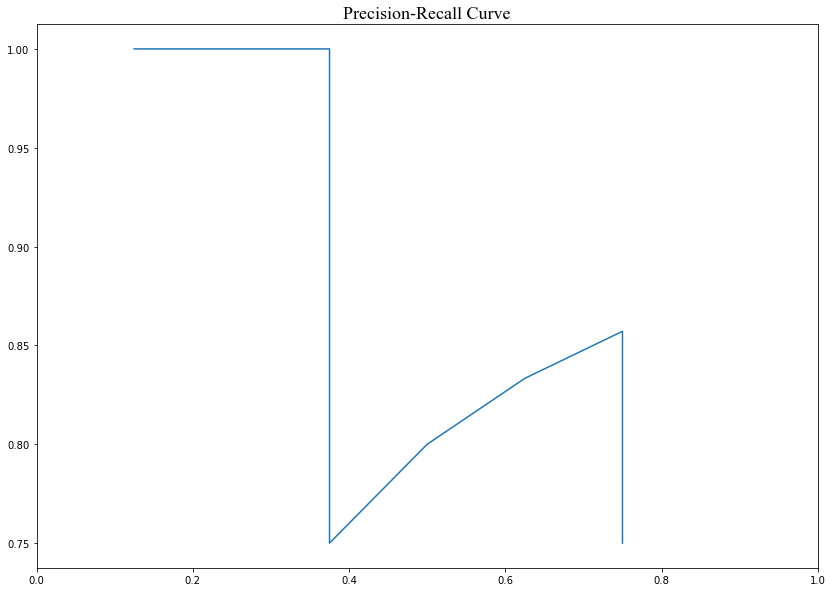

In [25]:
fig, ax = plt.subplots(1, figsize=(14, 10))
pr_curve = np.array(pr_curve)
plt.plot(pr_curve[:, 1], pr_curve[:, 0])
ax.set_xlim(0, 1.0)
ax.set_title('Precision-Recall Curve', fontsize=18, fontname='Times New Roman')

Make sure to check the `Desktop` to see your visualization when running the code.

In [ ]:
### From Udacity's `utils.py`

In [ ]:
def check_results(output):
    round_output = np.round(output * 1e4) / 1e4
    assert round_output == 0.7286, 'Something is wrong with the mAP calculation'
    print('mAP calculation is correct!')

In [ ]:
check_results(mAP)

## Tips

To create the PR curve, you need to sort the predictions based on their confidence score and calculate the precision and recall for each subset of the predictions, as explained in the course.

To make your life easier, you can hard code the smoothed PR curve based on the PR curve, but 
you should think of a scripted version of doing so.

## Credits

This assignment was prepared by Thomas Hossler et al., Winter 2021 (link [here](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)).

References
* [1] Everingham, M., et al., The PASCAL Visual Object Classes (VOC) Challenge. International Journal of Computer Vision. 88:303–338. 2010. [doi:10.1007/s11263-009-0275-4](https://doi.org/10.1007/s11263-009-0275-4).

* [2] Padilla, R., et al., A Comparative Analysis of Object Detection Metrics with a Companion Open-Source Toolkit. Electronics. 10(3):279. [doi:10.3390/electronics10030279](https://www.mdpi.com/2079-9292/10/3/279).


Helpful resources:
* [A Coder's Guide to IoU, Non-Max Suppression and Mean Average Precision by Vijayabhaskar J. | Medium](https://vijayabhaskar96.medium.com/practitioners-guide-to-iou-non-max-suppression-and-mean-average-precision-e09de73a2bd8)